# Transfer learning using EfficientNet_B3

**Paper:** `https://arxiv.org/abs/1905.11946`
**Model source:** `https://pytorch.org/vision/stable/models/efficientnet.html`

The model was selected due to it's promising acc/size ratio.

## Imports

In [1]:
import os
import sys

import torch
from torch import nn
import torchvision
from torchinfo import summary

from pathlib import Path
from sklearn.metrics import accuracy_score


# Get the absolute path of the project root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_preprocessing import split_train_test
from src.data_preprocessing import create_dataloader
from src.train_test import train
from src.plotting import show_sample_images
from src.plotting import plot_acc_and_loss
from src.plotting import identify_imgs

## Data handling and preparation

In [2]:
data_dir = os.path.join(project_root, 'data', 'flowers', 'train')

if os.path.exists(data_dir):
    split_train_test(data_dir)
else:
    print(f"The directory {data_dir} does not exist. Please check the path.")

train_dir = data_dir
test_dir = os.path.join(project_root, 'data', 'flowers', 'test')

Test directory already exists. Skipping split operation.


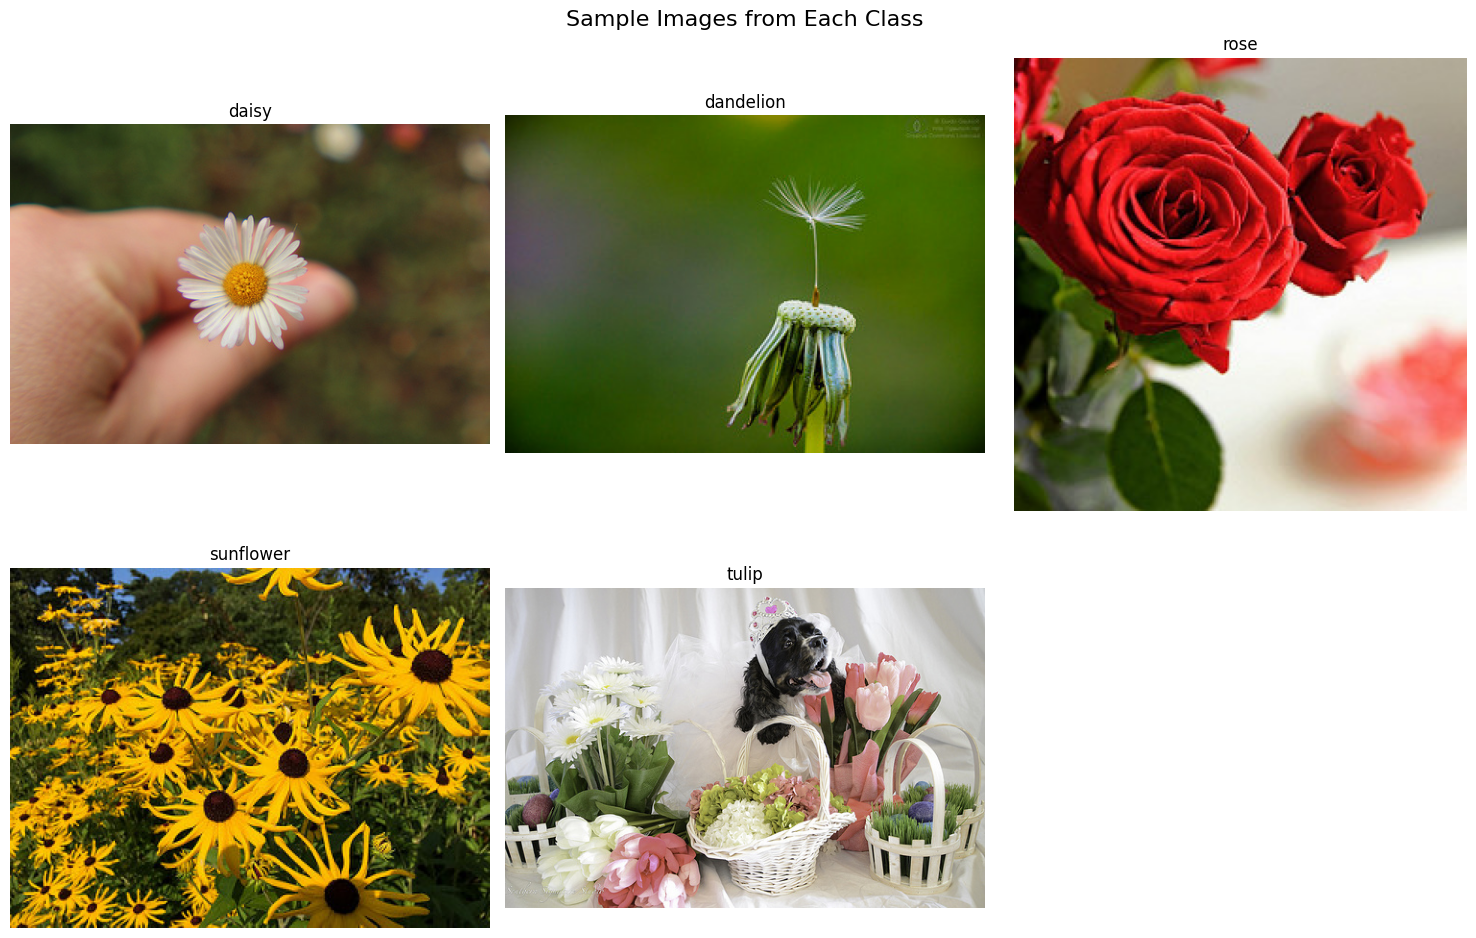

In [3]:
show_sample_images(train_dir)

In [ ]:
## P

In [4]:
BATCH_SIZE = 8
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
pre_trained_model_weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT 
auto_transforms = pre_trained_model_weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[300]
    resize_size=[320]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [6]:
train_dataloader, class_names = create_dataloader(dir=train_dir,
                   transform=auto_transforms,
                   batch_size=BATCH_SIZE,
                   shuffle=True)  

test_dataloader, _ = create_dataloader(dir=test_dir,
                   transform=auto_transforms,
                   batch_size=BATCH_SIZE,
                   shuffle=False)  

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x29b8f258250>,
 ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'])

## Model preparation

In [7]:
model = torchvision.models.efficientnet_b3(weights=pre_trained_model_weights).to(device)

In [8]:
summary(model=model,
        input_size=(1,3,300,300), #(batch_size, color channels, height, width),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 300, 300]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 300, 300]     [1, 1536, 10, 10]    --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 300, 300]     [1, 40, 150, 150]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 300, 300]     [1, 40, 150, 150]    1,080                True
│    │    └─BatchNorm2d (1)                                  [1, 40, 150, 150]    [1, 40, 150, 150]    80                   True
│    │    └─SiLU (2)                                         [1, 40, 150, 150]    [1, 40, 150, 150]    --                   --
│    └─Sequential (1)                                        [1, 40, 150, 150]    [1, 24, 150,

In [9]:
for param in model.features.parameters():
    param.requires_grad=False

In [10]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.0, inplace=True),
    nn.Linear(in_features=1536, out_features=len(class_names))).to(device)

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training

In [12]:
results=train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_score,
             epochs=10,#15
             device=device)

#print(results)

  0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 0.7583 | Train acc: 0.7536 |Test loss: 0.4147 | Test acc: 0.9058
Train loss: 0.4613 | Train acc: 0.8505 |Test loss: 0.3320 | Test acc: 0.9185
Train loss: 0.3980 | Train acc: 0.8683 |Test loss: 0.2945 | Test acc: 0.9257
Train loss: 0.3433 | Train acc: 0.8853 |Test loss: 0.2738 | Test acc: 0.9185
Train loss: 0.3265 | Train acc: 0.8895 |Test loss: 0.2429 | Test acc: 0.9203
Train loss: 0.3404 | Train acc: 0.8823 |Test loss: 0.2427 | Test acc: 0.9130
Train loss: 0.2978 | Train acc: 0.8982 |Test loss: 0.2295 | Test acc: 0.9348
Train loss: 0.2788 | Train acc: 0.9095 |Test loss: 0.2261 | Test acc: 0.9330
Train loss: 0.2887 | Train acc: 0.9020 |Test loss: 0.2388 | Test acc: 0.9257
Train loss: 0.2771 | Train acc: 0.9044 |Test loss: 0.2306 | Test acc: 0.9330

Train time on cuda:0: 216.913 seconds



## Evaluation

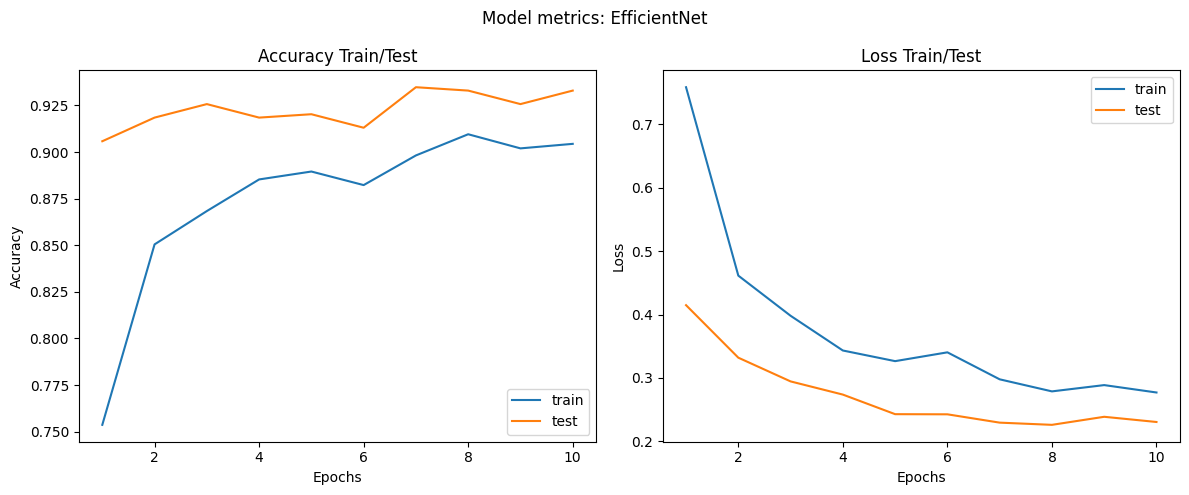

In [13]:
plot_acc_and_loss(results, model)

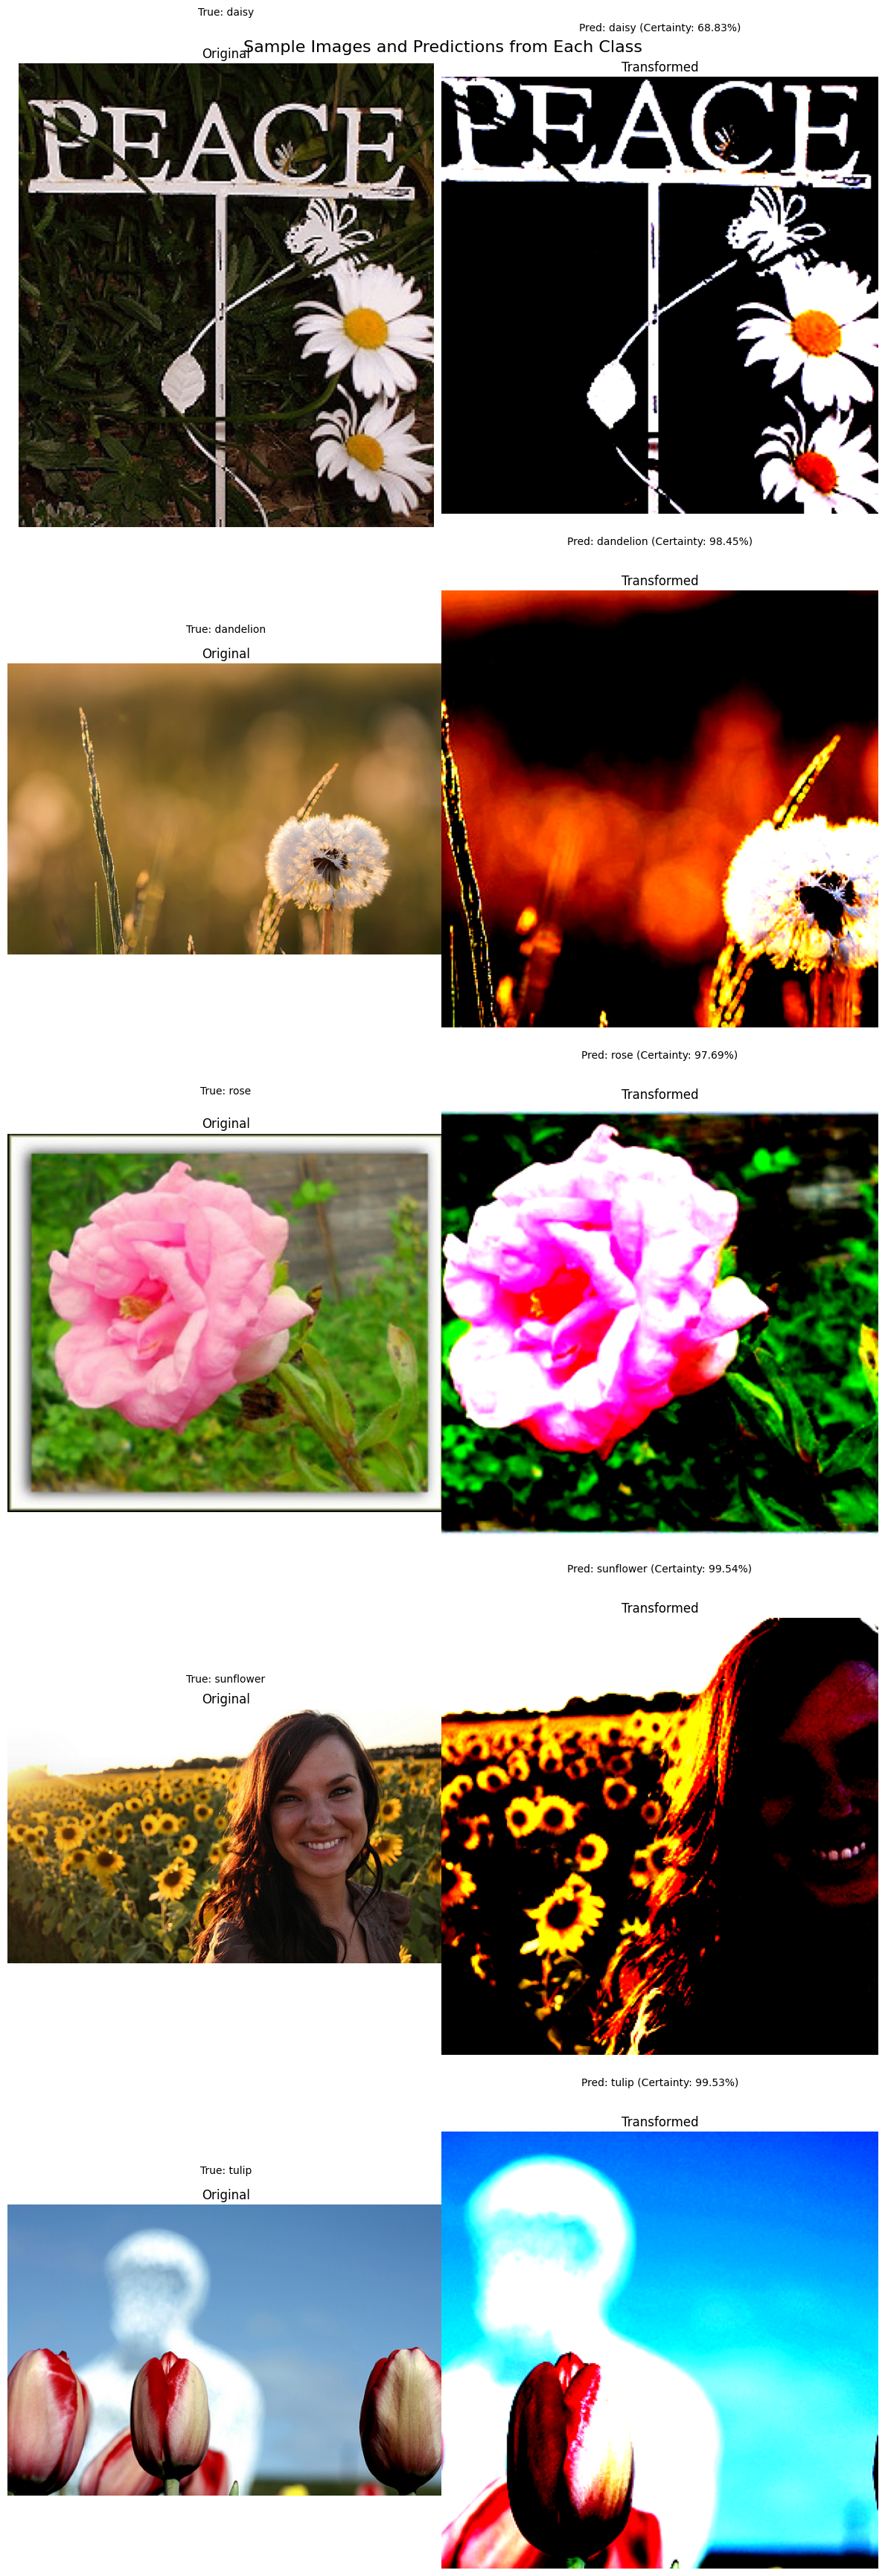

In [14]:
identify_imgs(model=model,
              base_folder=test_dir,
              class_names=class_names,
              transforms=auto_transforms,
              device=device)